In [27]:
# import needed libraries

# ema_workbench components needed
from ema_workbench.analysis import parcoords

# model functions needed
from problem_formulation import get_model_for_problem_formulation

# other libraries needed
import pickle # to read dictionaries
import pandas as pd # to deal with csv files and manipulate dataframes
import matplotlib.pyplot as plt # to plot
import numpy as np # to plot
import warnings
warnings.filterwarnings("ignore")

## Compute robustness after second optimization and re-evaluation

To compute robustness in this case we use a different metric, <code>maximum regret</code>: for each policy, for each scenario regret is computed as the difference between the performance of the policy and the the best possible result in the scenario under study. The maximum regret for a policy is the maximum of the regret values of that policy for all the scenarios (N.B.: this is done for all the outcomes separately). The policies with low regrets are the ones that are performing the best over all the scenarios and thus are more robust.

In [2]:
# import the data from the second re-evaluation
experiments = pd.read_csv("intermediate outputs/step6 - second re-evaluation - experiments description.csv")

outcomes_file = open("intermediate outputs/step6 - second re-evaluation - outcomes description.pkl", "rb")
outcomes = pickle.load(outcomes_file)

In [3]:
#calculating the maximum regret 
overall_regret = {}
max_regret = {}
regret = []

for scenario in experiments.scenario.unique(): # for each scenario
    logical = experiments.scenario==scenario # used to select the experiments regarding this scenario
    
    # for each scenario we get the values of the outcomes of all the policies that we are considering
    temp_results = {k:v[logical] for k,v in outcomes.items()} 
    temp_results = pd.DataFrame(temp_results) # make a dataframe out of the outcomes
    temp_experiments = experiments[experiments.scenario==scenario] # get the experiments description for the scenario
    
    best = temp_results.min() # a series containing for each outcome the minimum value (the best possible outcome)
    # for each policy it computes the difference between the policies performances and the best values, the regret
    scenario_regret = temp_results - best 
    scenario_regret['policy'] = temp_experiments.policy.values # add the name of the policy    
    regret.append(scenario_regret) # save the scenario_regret
    
    
regret = pd.concat(regret) # unify in a single dataframe all the regrets values

# for each policy and each outcome you get the highest regret they ever scored (among all the policies)
maxregret = regret.groupby('policy').max() 

In [4]:
len(maxregret)

628

Since there are still a lot of policies left, to faciliate the analysis via <code>Parallel Coordinates Plots</code> we reduce the policies by choosing the ones that are in the lowest percentile for the deeaths of our client's dike, 4 and 5, and the other dikes. This is done because our client highly values safety. We chose the percentile number via trial and error.

In [5]:
data = maxregret.copy(deep=True)

In [6]:
# we combine the deaths for dike ring 4 and 5 so not to have to make a choice between what dike ring to prioritize first
data['Dike 4 & 5 - Total deaths'] = data['A.4_Expected Number of Deaths'] + data['A.5_Expected Number of Deaths']

In [7]:
data = data.loc[data['Dike 4 & 5 - Total deaths'] < np.percentile(data['Dike 4 & 5 - Total deaths'], 10)]
data = data.loc[data['Other.Dikes_Expected Number of Deaths'] < np.percentile(data['Other.Dikes_Expected Number of Deaths'], 10)]

In [8]:
data[['A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths', 'Other.Dikes_Expected Number of Deaths']]

,A.4_Expected Number of Deaths,A.5_Expected Number of Deaths,Other.Dikes_Expected Number of Deaths
policy,,,
scenario 0 option 1710,0.000148,0.001242,0.007199
scenario 0 option 1944,0.000000,0.000621,0.002499
scenario 0 option 2361,0.000000,0.000808,0.015643
scenario 0 option 2610,0.000093,0.000560,0.002499
scenario 0 option 2864,0.000000,0.000000,0.015643
scenario 0 option 3794,0.000224,0.001121,0.017525
scenario 0 option 3990,0.000026,0.000560,0.005214


In [9]:
len(data)

7

We now have 7 policies that we can easily plot.

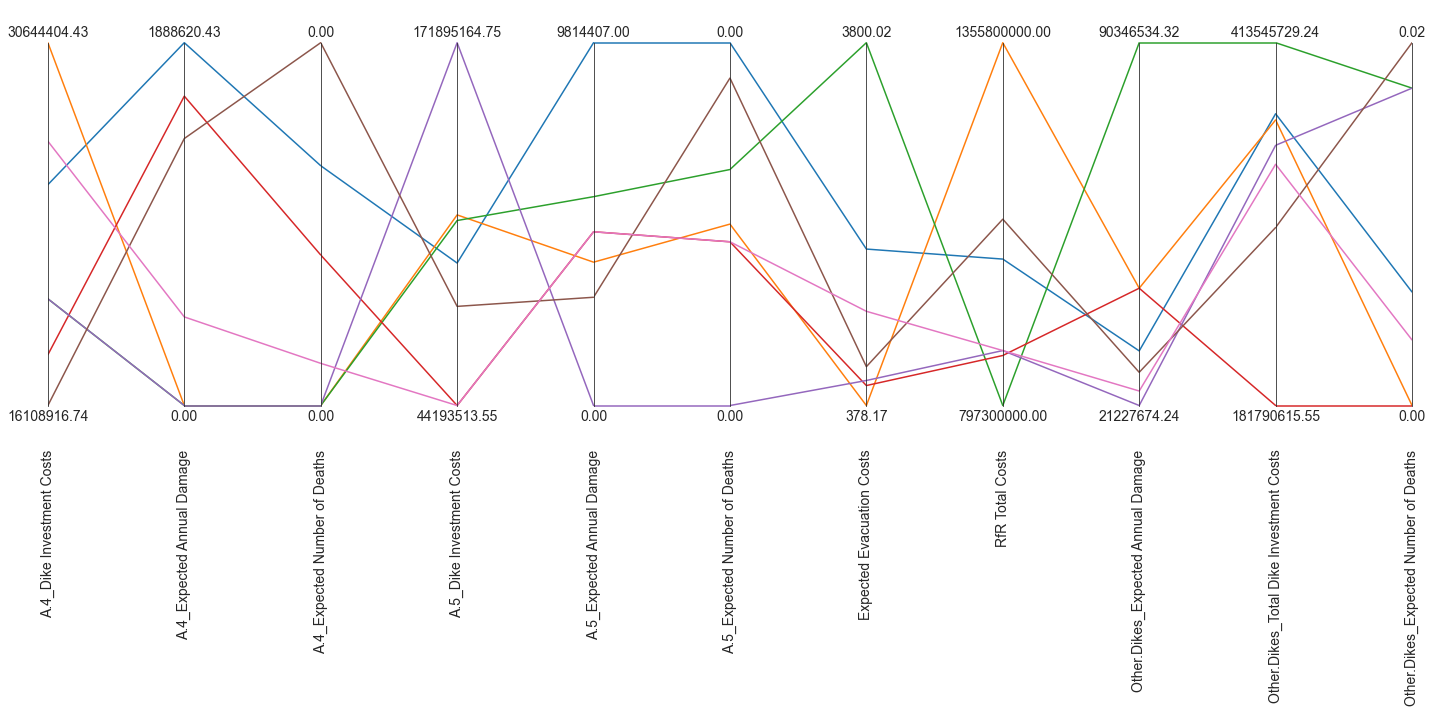

In [15]:
temp = data.drop(columns=['Dike 4 & 5 - Total deaths']) # remove this column for the plot

# set up the parallel coordinate plot using the ema_workbench librairy functions
limits = parcoords.get_limits(temp)
paraxes = parcoords.ParallelAxes(temp)
paraxes.plot(temp)
plt.rcParams["figure.figsize"]=(20,10) # fix the size of the picture

# save figure
plt.savefig('output pictures/step7 - robustness of selected policies.png')

plt.show()

From this picture, we can't get a picture that has the lowest regret for majority of outcomes, not even just for the deaths. We need a new criterion to choose the best policy for our client, the one they could support and pursue. To achieve this we go back to one of their values: they want "<b>shared responsibility</b>", both for benefits and burdens. In line with this, we find the policy that has the most equal distribution for the key burdens of the proble, deaths, among the dike rings.

To get such policy, we compute the standard deviation across the deaths outcomes for each policy. We then pick the policy with the lowest standard deviation.

In [17]:
data = data.reset_index()

# compute the standard deviation across each policy
std_values=[]
for index, row in data.iterrows():
    std_values.append(np.std([row["A.4_Expected Number of Deaths"], row["A.5_Expected Number of Deaths"], row["Other.Dikes_Expected Number of Deaths"]]))
data['std'] = std_values

In [18]:
data[['A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths', 'Other.Dikes_Expected Number of Deaths', 'std']]

,A.4_Expected Number of Deaths,A.5_Expected Number of Deaths,Other.Dikes_Expected Number of Deaths,std
0,0.000148,0.001242,0.007199,0.003099
1,0.000000,0.000621,0.002499,0.001062
2,0.000000,0.000808,0.015643,0.007191
3,0.000093,0.000560,0.002499,0.001042
4,0.000000,0.000000,0.015643,0.007374
5,0.000224,0.001121,0.017525,0.007953
6,0.000026,0.000560,0.005214,0.002330


In [31]:
best_policy_regret = data.loc[data['std'] == data['std'].min()]
best_policy_regret

,index,policy,A.4_Dike Investment Costs,A.4_Expected Annual Damage,A.4_Expected Number of Deaths,A.5_Dike Investment Costs,A.5_Expected Annual Damage,A.5_Expected Number of Deaths,Expected Evacuation Costs,RfR Total Costs,Other.Dikes_Expected Annual Damage,Other.Dikes_Total Dike Investment Costs,Other.Dikes_Expected Number of Deaths,Dike 4 & 5 - Total deaths,std
3,3,scenario 0 option 2610,1.814408e+07,1.610260e+06,0.000093,4.419351e+07,4.699394e+06,0.00056,566.469772,874300000.0,4.357418e+07,1.817906e+08,0.002499,0.000653,0.001042


This is the policy that has the lowest standard variation. Because of its values, we can understand it is the policy in <font color=red>red</font>.

We can get the description of the policy out of the results of the second optimization.

In [25]:
# get the detail of the policy out of the second optimization results
policy_descriptions = pd.read_csv("intermediate outputs/step5 - multi scenario optimization results/step5 - 0 optimization results.csv")
policy_descriptions = policy_descriptions.drop(columns=['Unnamed: 0']) # cleaning

In [28]:
# prepare the model object
dike_model, planning_steps = get_model_for_problem_formulation(6)

In [34]:
best_policy_description = policy_descriptions.loc[policy_descriptions.index == 2610][[o.name for o in dike_model.levers]]
best_policy_description.to_csv("intermediate outputs/step7 - best policy description.csv")
best_policy_description

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
2610,1,1,0,0,1,1,1,1,1,1,...,0,7,0,2,9,0,0,7,0,0
